In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import os

In [2]:
def _get_metrics_from_tensorboard(event_acc, scalar):
    train_metrics, val_metrics = event_acc.Scalars(f'{scalar}/train'), event_acc.Scalars(f'{scalar}/valid')
    train_df, val_df = pd.DataFrame(train_metrics), pd.DataFrame(val_metrics)

    train_df.drop(columns=['wall_time'], inplace=True)
    val_df.drop(columns=['wall_time'], inplace=True)

    train_df.rename(columns={'value': f'train_{scalar}'}, inplace=True)
    val_df.rename(columns={'value': f'val_{scalar}'}, inplace=True)
    results = pd.merge(train_df, val_df, on='step', how='outer')
    results = results.dropna()
    results = results.drop(columns=['step'])
    return results

def graph_and_metrics(loss, acc, prec, rec, experiment_name):
    result_keys = {
        'BCE Loss': loss,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec
    }

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    fig.suptitle(f'Loss, Accuracy, Precision, Recall for {experiment_name}', fontsize=16)

    results_matrix = pd.concat([loss, acc, prec, rec], axis=1)
    for i, (key, value) in enumerate(result_keys.items()):
        fig_ = sns.lineplot(value, ax=axes[i])
        fig_.set(xlabel='Epoch', ylabel=key, title=key)
    return results_matrix

def top_metrics(results):
    metric_container = []
    for experiment_name, df in results.items():
        metric_container.append(_best_metrics(df, experiment_name))
    
    return pd.DataFrame(metric_container)

def tensorboard_results(log_dir_list, experiment_name):

    loss_list, acc_list, prec_list, rec_list = [], [], [], []

    for log_dir in log_dir_list:
        print(f'Processing {log_dir}...')
        events = EventAccumulator(log_dir)
        events.Reload()
        
        loss_list.append(_get_metrics_from_tensorboard(events, 'loss_e'))
        acc_list.append(_get_metrics_from_tensorboard(events, 'acc'))
        prec_list.append(_get_metrics_from_tensorboard(events, 'prec'))
        rec_list.append(_get_metrics_from_tensorboard(events, 'rec'))


    for df_list in [loss_list, acc_list, prec_list, rec_list]:
        for indx, df_index in enumerate(df_list):
            if indx != len(df_list) - 1:
                cutoff = df_list[indx + 1].shape[0]
                df_index = df_index.head(100 - cutoff)
                print(df_index.shape)

    loss, acc, prec, rec = (
        pd.concat(loss_list).reset_index().drop(columns=['index']),
        pd.concat(acc_list).reset_index().drop(columns=['index']),
        pd.concat(prec_list).reset_index().drop(columns=['index']),
        pd.concat(rec_list).reset_index().drop(columns=['index'])
    )

    return graph_and_metrics(loss, acc, prec, rec, experiment_name)

def _best_metrics(df, name):

    # last row from columns
    return {
        'Experiment': name,
        'BCE Loss Train': df['train_loss_e'].iloc[-1].round(4),
        'BCE Loss': df['val_loss_e'].iloc[-1].round(4),
        'Accuracy': df['val_acc'].iloc[-1].round(4),
        'Precision': df['val_prec'].iloc[-1].round(4),
        'Recall': df['val_rec'].iloc[-1].round(4),
    }


In [3]:
seq_10 = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_10/None/2023_02_07_14_49/version_0'
]

seq_20 = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_20/None/2023_02_08_08_27/version_0'
]

seq_30 = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_07_21_44/version_0'
]

seq_40 = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_08_08_15/version_0',
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_08_21_22/version_0'
]

seq_10_heuristic = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_10/None/2023_02_09_11_08/version_0'
]

seq_20_heuristic = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_20/None/2023_02_09_19_22/version_0'
]

seq_30_heuristic = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_10_09_39/version_0',
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_10_16_33/version_0'
]

seq_40_heuristic = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_10_17_48/version_0',
    's3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_12_08_49/version_0'
]

embedding_project_user = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/embedded/sequence_length_40/None/2023_02_14_15_10/version_0'
]

embedding_user = [
    's3://dissertation-data-dmiller/lstm_experiments/results/61/embed_user/sequence_length_40/None/2023_02_15_09_43/version_0'
]


Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/embedded/sequence_length_40/None/2023_02_14_15_10/version_0...


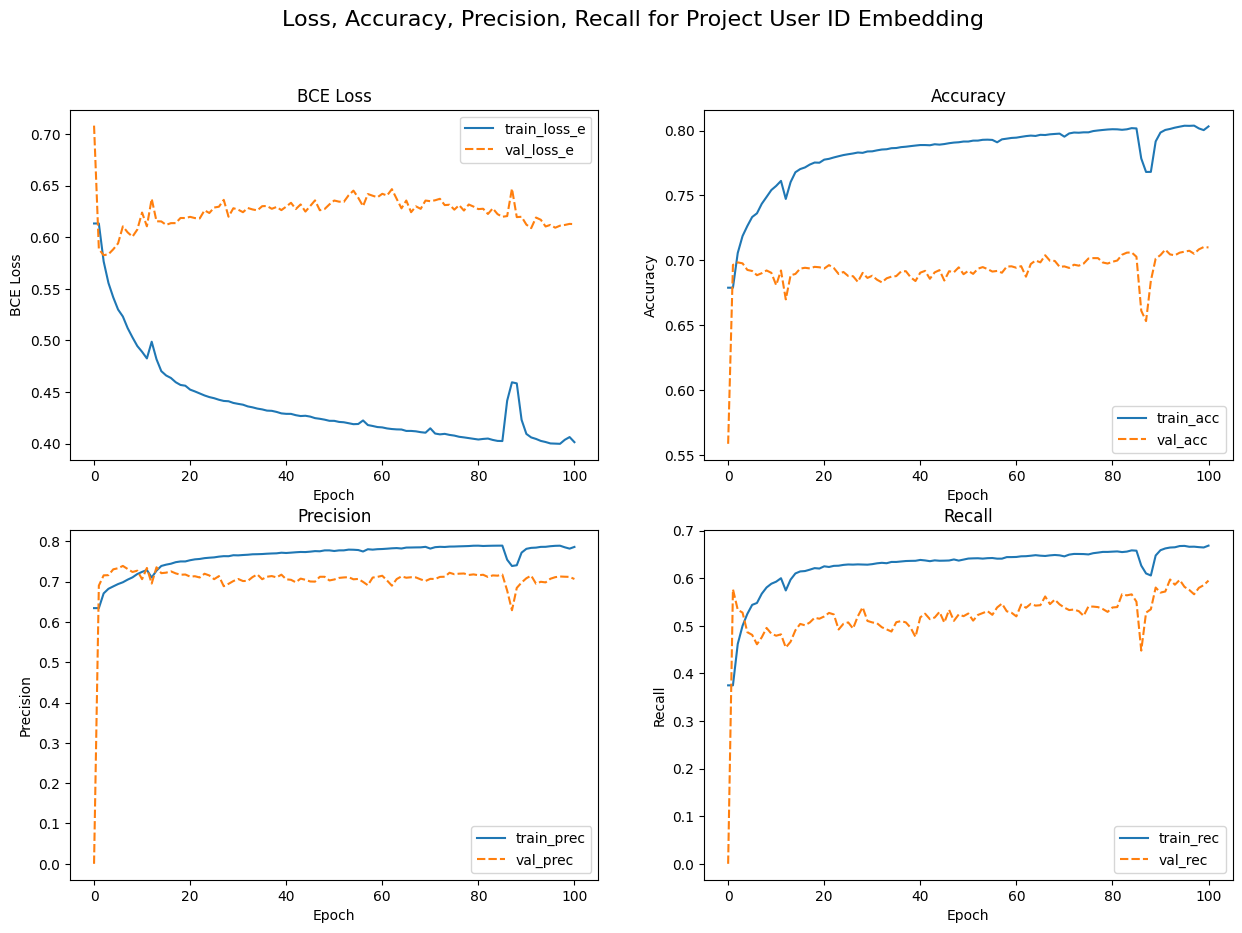

In [4]:
embedding_project_user_res = tensorboard_results(embedding_project_user, 'Project User ID Embedding')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/embed_user/sequence_length_40/None/2023_02_15_09_43/version_0...


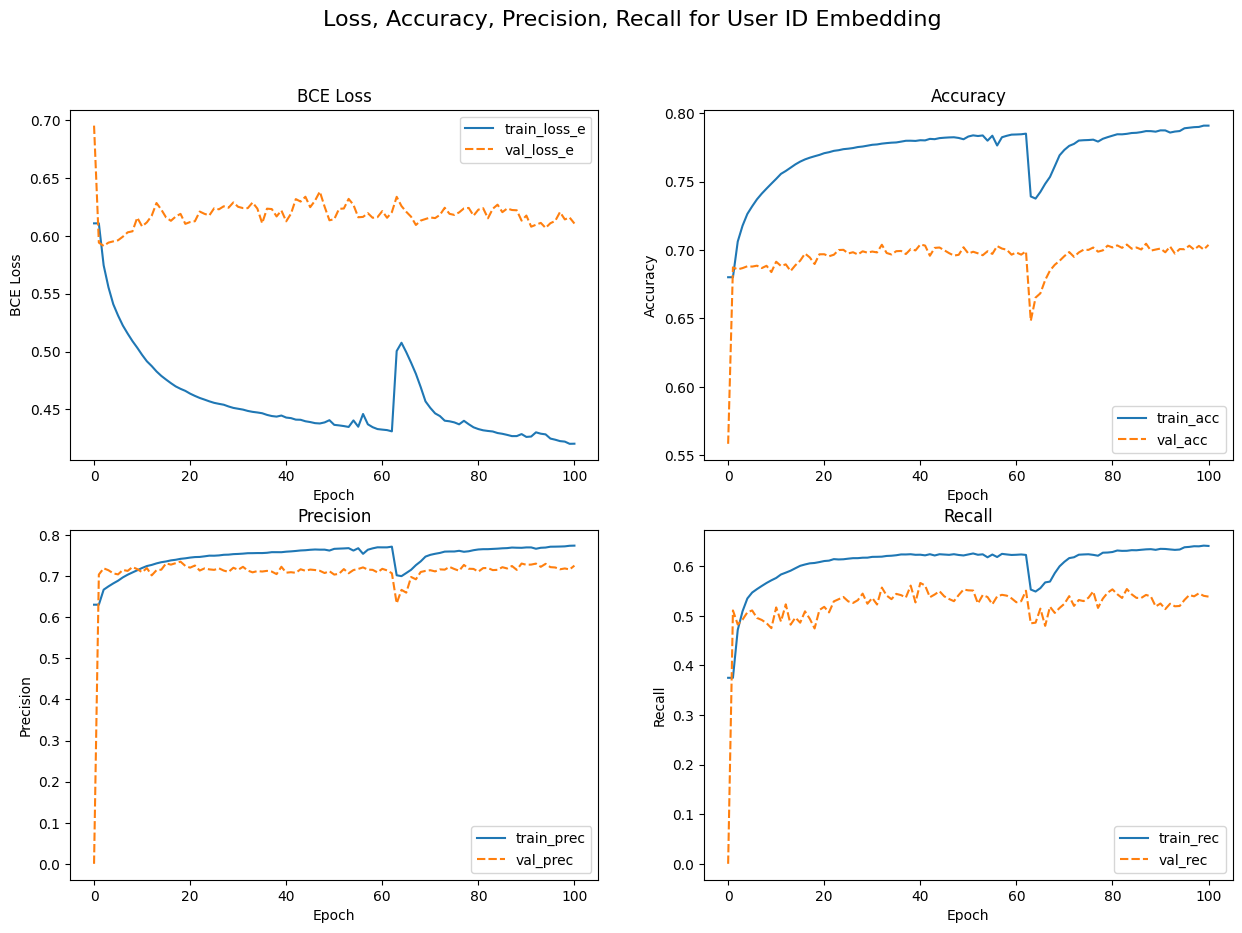

In [5]:
emmbedding_user_res = tensorboard_results(embedding_user, 'User ID Embedding')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_10/None/2023_02_07_14_49/version_0...


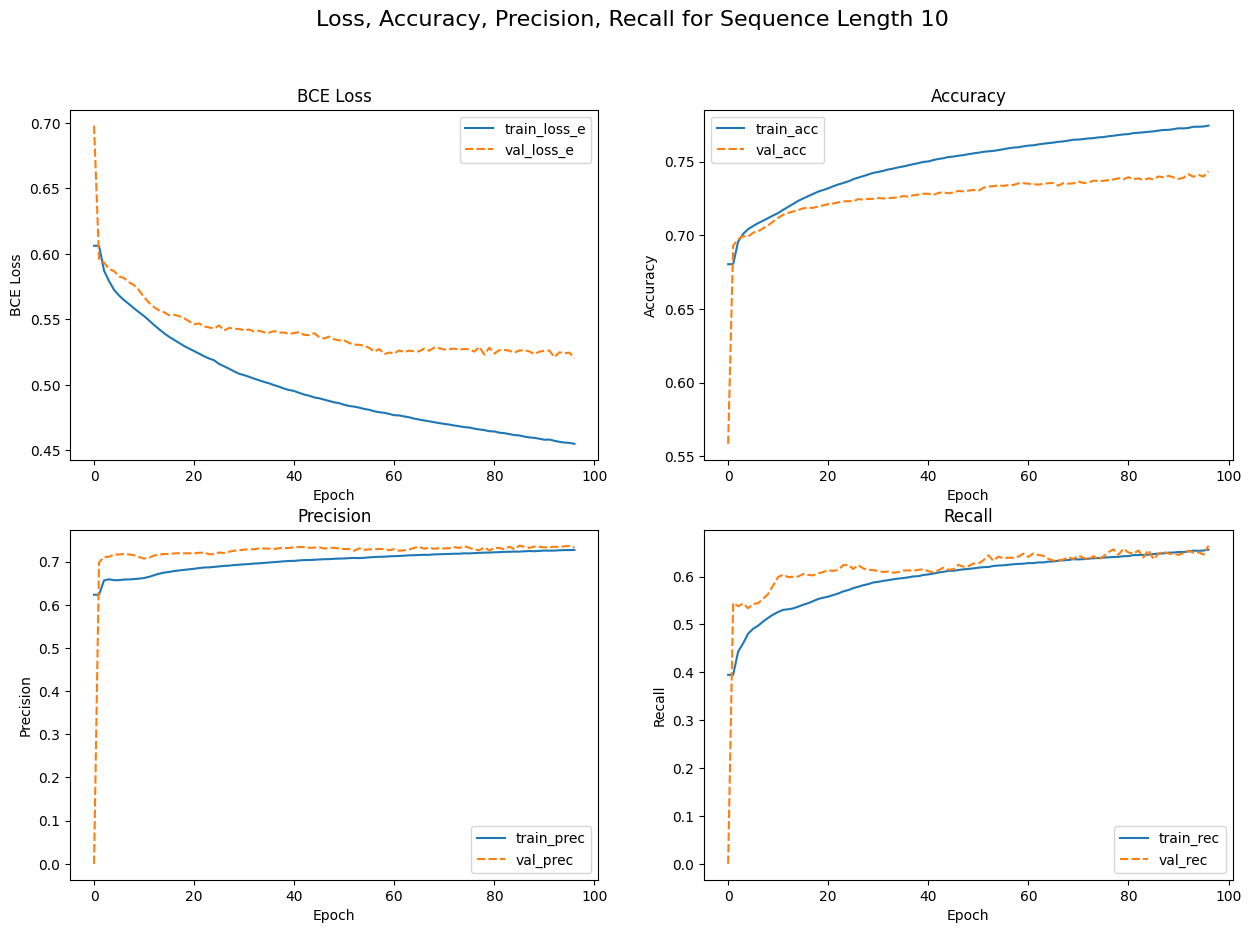

In [7]:
seq_10_res = tensorboard_results(seq_10, 'Sequence Length 10')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_20/None/2023_02_08_08_27/version_0...


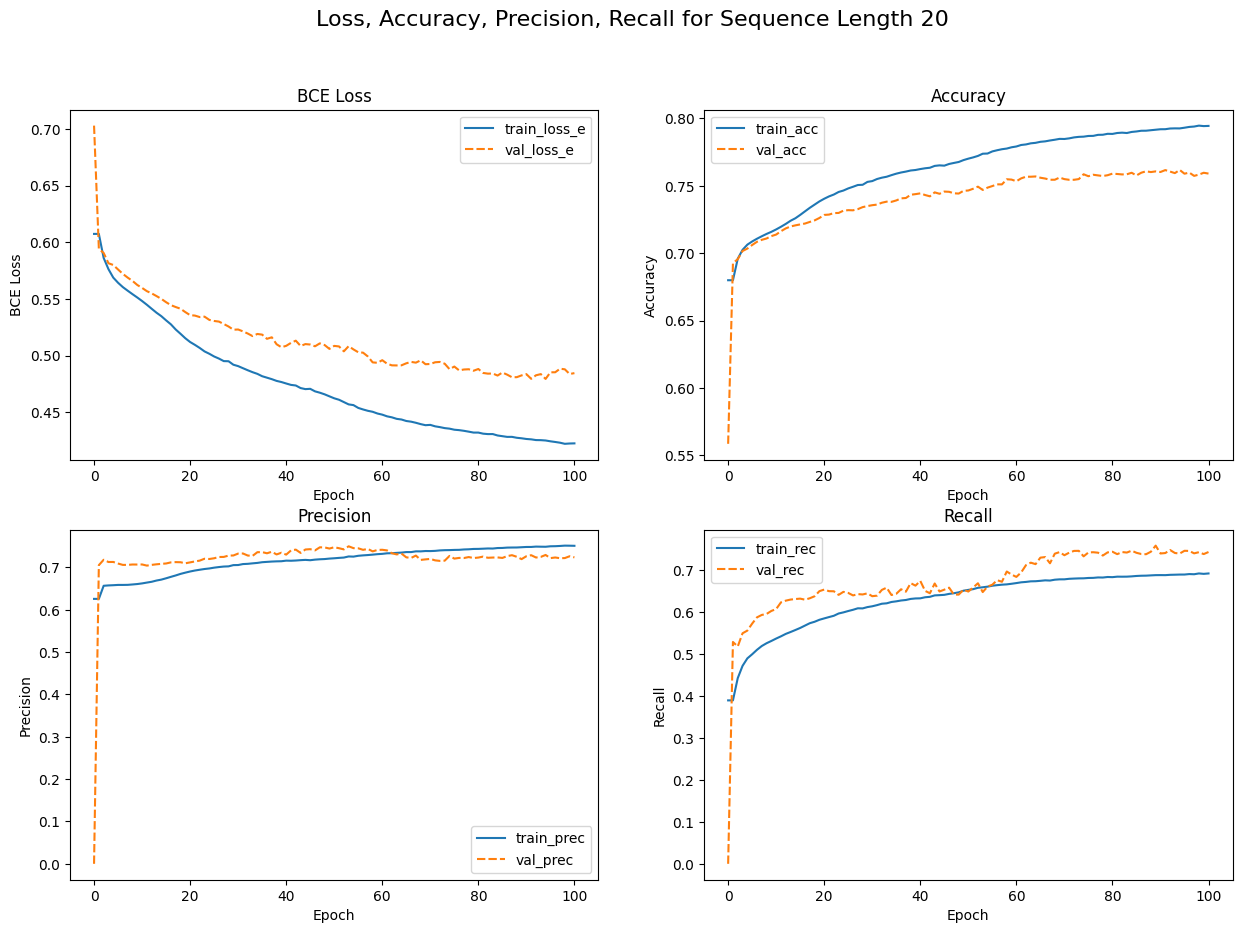

In [8]:
seq_20_res = tensorboard_results(seq_20, 'Sequence Length 20')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_07_21_44/version_0...


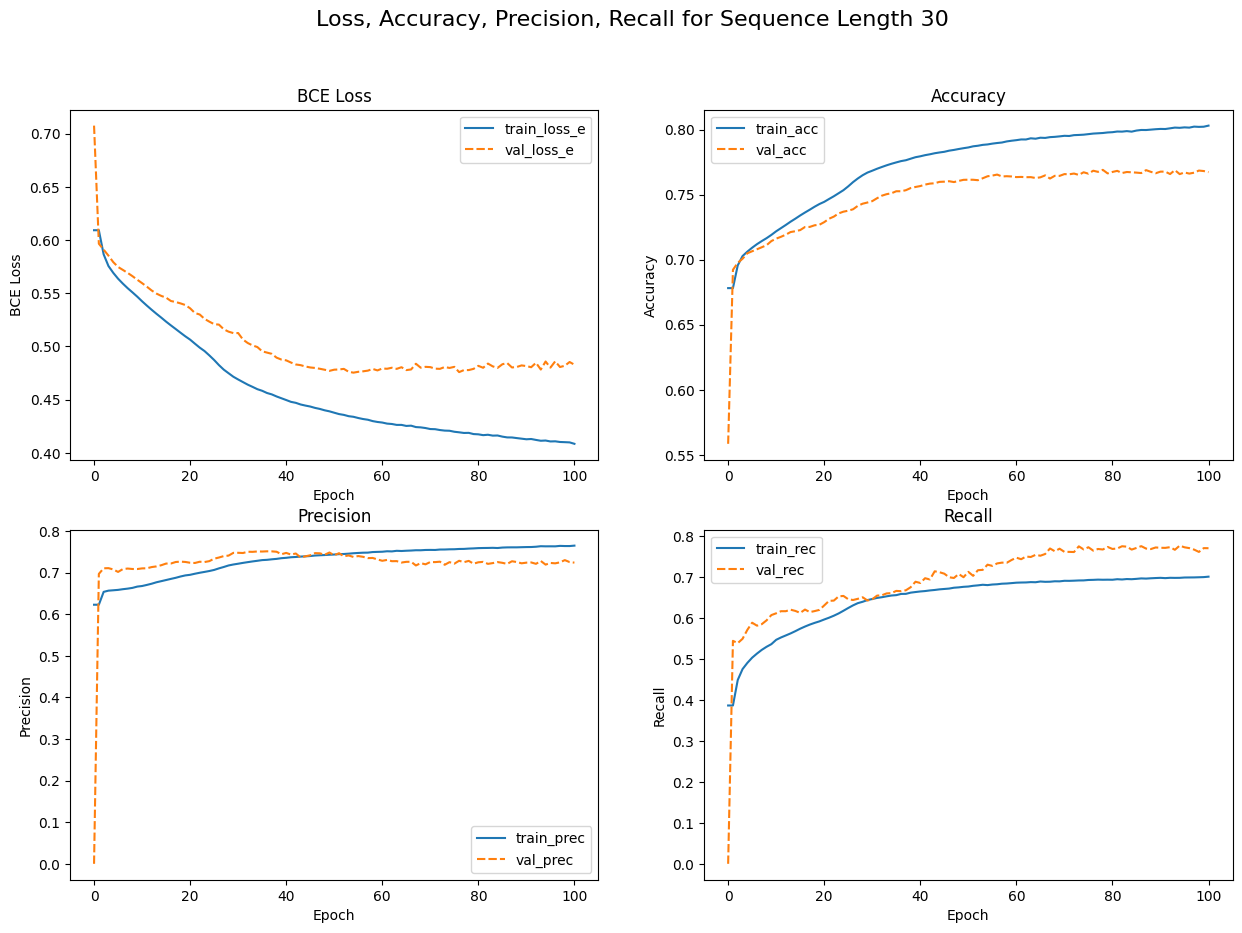

In [9]:
seq_30_res = tensorboard_results(seq_30, 'Sequence Length 30')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_08_08_15/version_0...
Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_08_21_22/version_0...
(76, 2)
(76, 2)
(76, 2)
(76, 2)


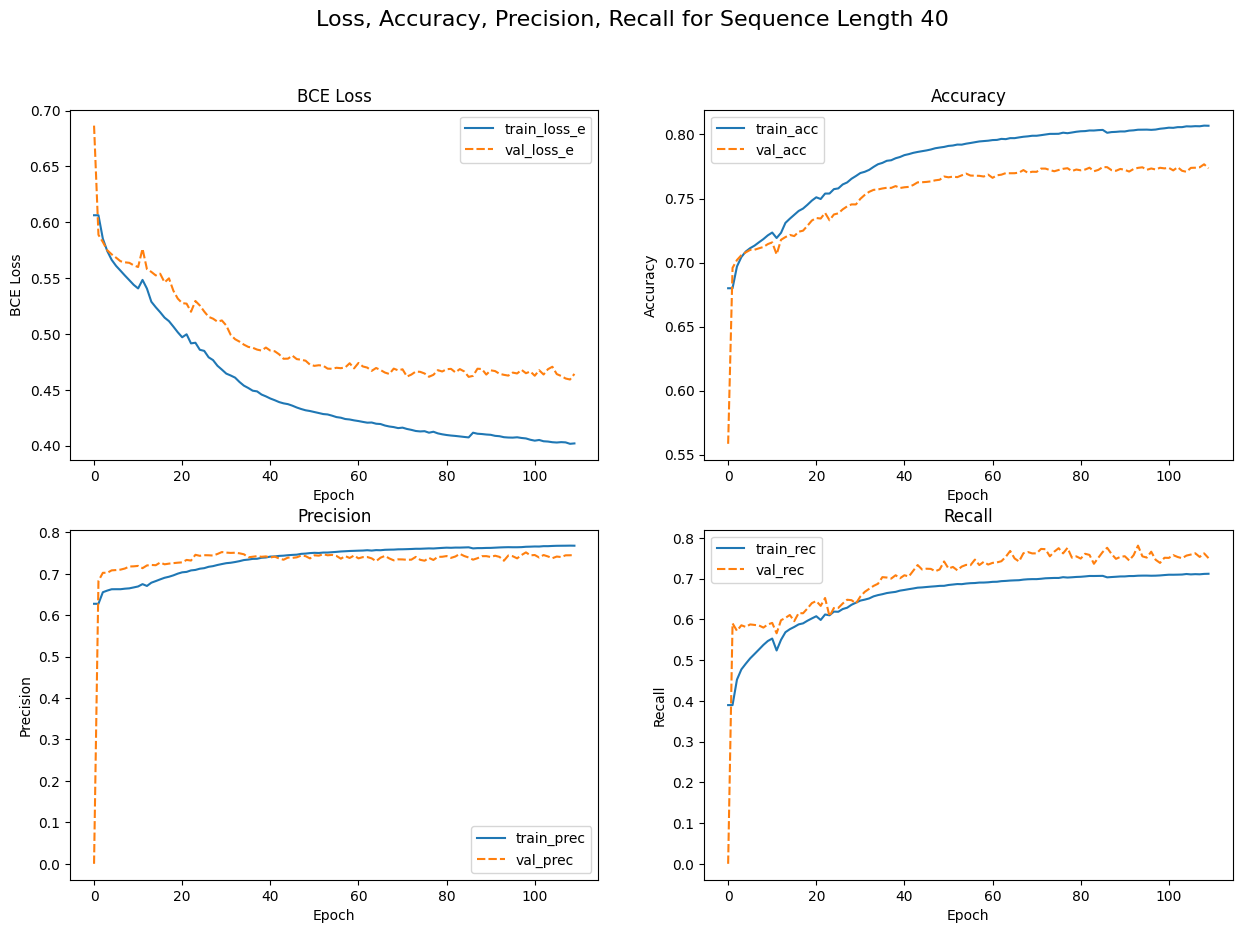

In [10]:
seq_40_res = tensorboard_results(seq_40, 'Sequence Length 40')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_10/None/2023_02_09_11_08/version_0...


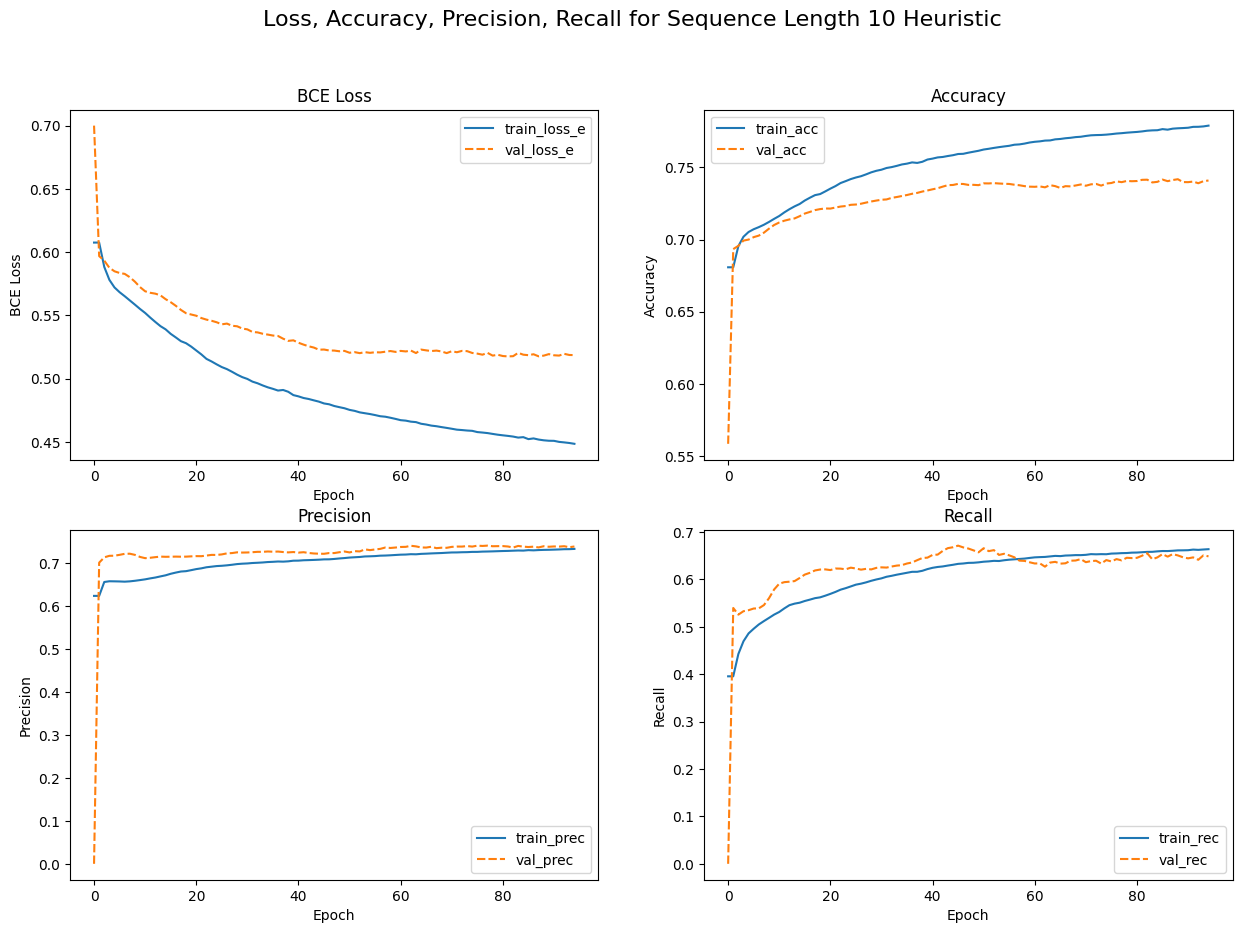

In [11]:
seq_10_heuristic = tensorboard_results(seq_10_heuristic, 'Sequence Length 10 Heuristic')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_20/None/2023_02_09_19_22/version_0...


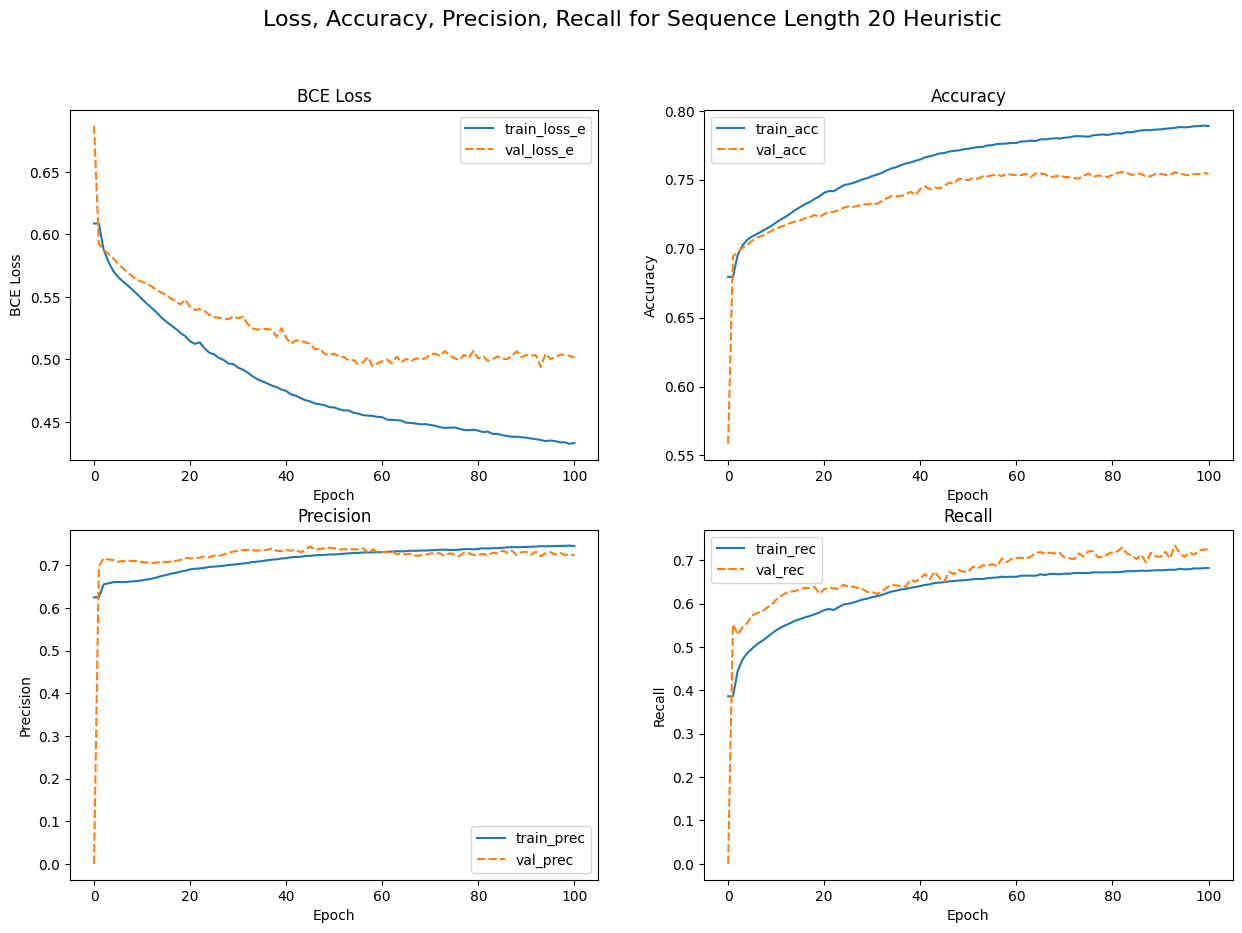

In [12]:
seq_20_heuristic = tensorboard_results(seq_20_heuristic, 'Sequence Length 20 Heuristic')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_10_09_39/version_0...
Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_30/None/2023_02_10_16_33/version_0...
(88, 2)
(88, 2)
(88, 2)
(88, 2)


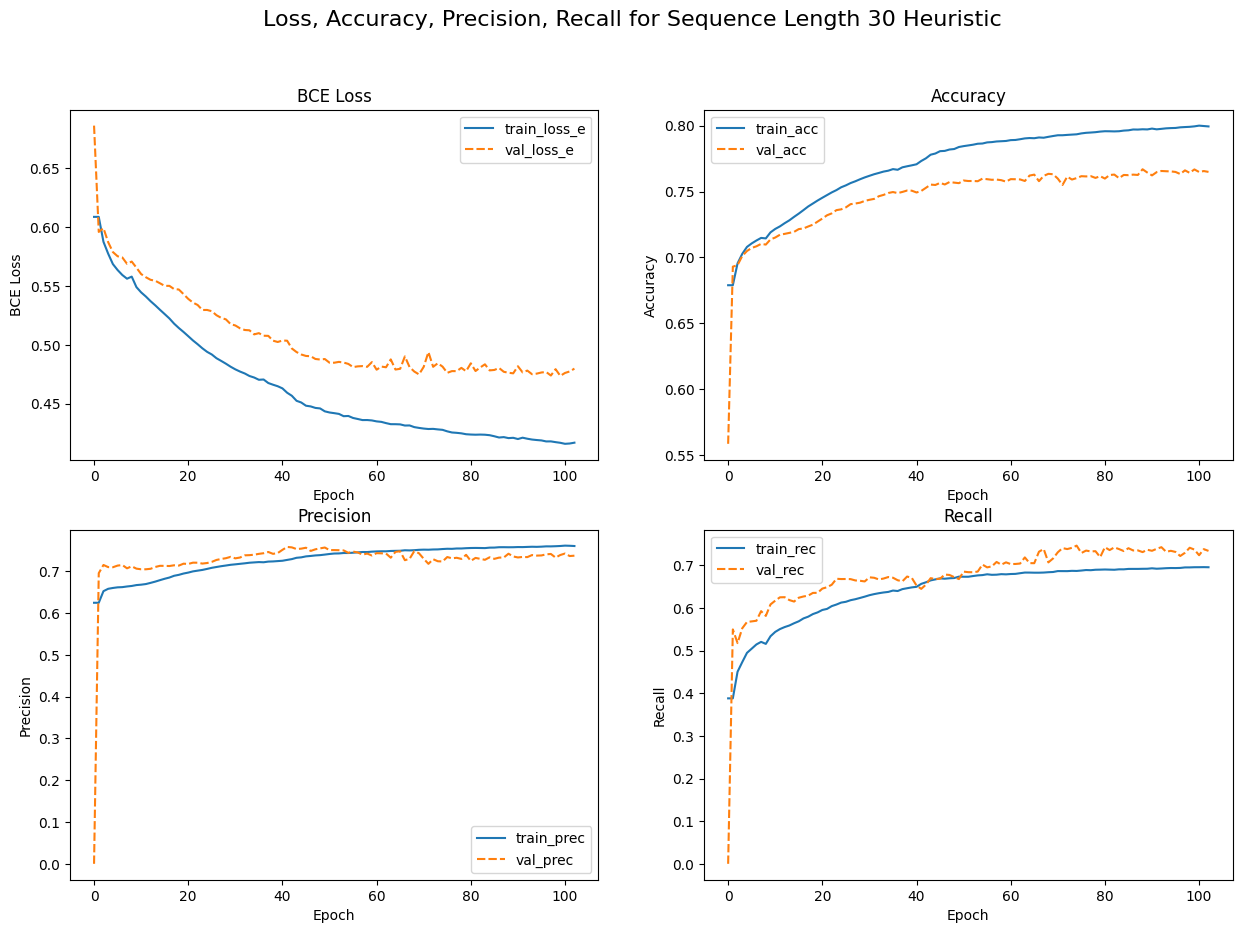

In [13]:
seq_30_heuristic = tensorboard_results(seq_30_heuristic, 'Sequence Length 30 Heuristic')

Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_10_17_48/version_0...
Processing s3://dissertation-data-dmiller/lstm_experiments/results/61/ordinal/sequence_length_40/None/2023_02_12_08_49/version_0...
(50, 2)
(50, 2)
(50, 2)
(50, 2)


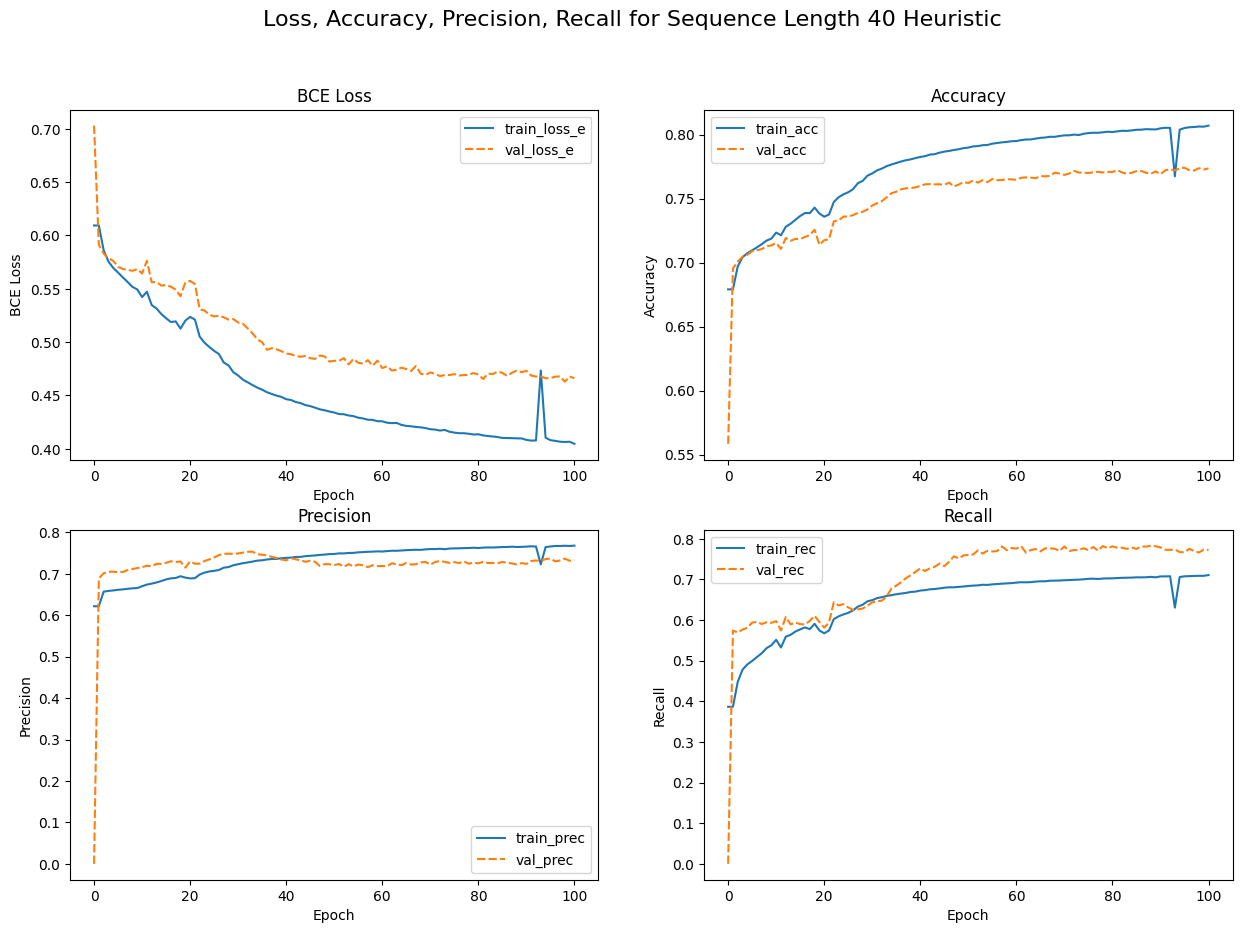

In [14]:
seq_40_heuristic = tensorboard_results(seq_40_heuristic, 'Sequence Length 40 Heuristic')

In [18]:
metric = top_metrics({
    'Sequence Length 10': seq_10_res,
    'Sequence Length 20': seq_20_res,
    'Sequence Length 30': seq_30_res,
    'Sequence Length 40': seq_40_res,
    'Sequence Length 10 Heuristic': seq_10_heuristic,
    'Sequence Length 20 Heuristic': seq_20_heuristic,
    'Sequence Length 30 Heuristic': seq_30_heuristic,
    'Sequence Length 40 Heuristic': seq_40_heuristic,
    'Project User ID Embedding': embedding_project_user_res,
    'User ID Embedding': emmbedding_user_res,
})

In [19]:
metric

,Experiment,BCE Loss Train,BCE Loss,Accuracy,Precision,Recall
0,Sequence Length 10,0.4551,0.5204,0.7433,0.7324,0.6647
1,Sequence Length 20,0.4225,0.4845,0.7591,0.7237,0.7435
2,Sequence Length 30,0.4085,0.4828,0.7673,0.7242,0.7700
3,Sequence Length 40,0.4019,0.4642,0.7736,0.7452,0.7504
4,Sequence Length 10 Heuristic,0.4484,0.5186,0.7409,0.7386,0.6486
5,Sequence Length 20 Heuristic,0.4332,0.5016,0.7545,0.7245,0.7245
6,Sequence Length 30 Heuristic,0.4168,0.4798,0.7649,0.7376,0.7339
7,Sequence Length 40 Heuristic,0.4047,0.4663,0.7736,0.7334,0.7726
8,Project User ID Embedding,0.4014,0.6127,0.7099,0.7063,0.5950
9,User ID Embedding,0.4203,0.6107,0.7038,0.7257,0.5387


In [16]:
metric.to_csv('sequence_length_metrics_dataset_61_no_heuristic.csv', index=False)

In [17]:
import pprint as pp
print(metric.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
                  Experiment &  BCE Loss Train &  BCE Loss &  Accuracy &  Precision &  Recall \\
\midrule
          Sequence Length 10 &          0.4551 &    0.5204 &    0.7433 &     0.7324 &  0.6647 \\
          Sequence Length 20 &          0.4225 &    0.4845 &    0.7591 &     0.7237 &  0.7435 \\
          Sequence Length 30 &          0.4085 &    0.4828 &    0.7673 &     0.7242 &  0.7700 \\
          Sequence Length 40 &          0.4019 &    0.4642 &    0.7736 &     0.7452 &  0.7504 \\
Sequence Length 10 Heuristic &          0.4484 &    0.5186 &    0.7409 &     0.7386 &  0.6486 \\
Sequence Length 20 Heuristic &          0.4332 &    0.5016 &    0.7545 &     0.7245 &  0.7245 \\
Sequence Length 30 Heuristic &          0.4168 &    0.4798 &    0.7649 &     0.7376 &  0.7339 \\
Sequence Length 40 Heuristic &          0.4047 &    0.4663 &    0.7736 &     0.7334 &  0.7726 \\
   Project User ID Embedding &          0.4014 &    0.6127 &    0.7099 &     0.7063 &

/var/folders/ff/4q6bhhgj28n5wdjn7n8wzcdm0000gn/T/ipykernel_10431/2895534520.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(metric.to_latex(index=False))
